In [10]:
from pathlib import Path

import numpy as np
import math 
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
from collections import Counter

from georules.S_ProbMap import Lobe_map
from georules.variance_bathymetry import varinace_bathymetry_maps
from georules.utils import save_bath_as_array
from georules.S_3Dgrid_healing import sandbox
from georules.visualization.V_grid import grid
from georules.utils import load_list_json
from georules.utils import load_array
from georules.utils import save_bath_as_array
from georules.utils import save_list_as_json
from georules.utils import save_centroids
from georules.utils import save_array

import warnings
warnings.filterwarnings('ignore')

# Constants
RESULTS_DIR = Path("./results")

In [8]:
#Reservoir Parameter Settings
wmax=[15000] #m
tmax=[2] #m
lenght =[30000] #m 
lobes = [30] #number of lobes
cellsize = [100] #cell size
nx = [250]
ny = [250]
t_matrix = [np.array([[0.1,0.13,0.3,0.15,0.22,0.1],
                     [0.3,0.05,0.3,0.15,0.15,0.05],
                     [0.3,0.13,0.1,0.15,0.18,0.14],
                     [0.25,0.1,0.25,0.09,0.22,0.09],
                     [0.05,0.25,0.25,0.25,0.05,0.15],
                     [0.15,0.25,0.25,0.25,0.05,0.05]])] #transition matrix
start_state = ["Q2"] # start states can be ["Q1","Q2","Q3","Q4","NMA","HF"]
quadrant_angles = [ {"Q1": [315,45],"Q2":[45,135],"Q3":[135,225],"Q4":[225,315]}] #lists of quadrants with their angles
source = [[25,200]] #source of the sediment (channel)
a1 = [0.66]
a2  = [0.33]
gp = [0.15]
cellsize_z =  [0.15]
n_mud = [2] #number of cells mud that covers lobe
mud_property = [0.18] #property mud
states = ["Q1", "Q2", "Q3", "Q4", "NMA", "HF"]

In [9]:
num_reals = 1

n = 1
n_tests = 300

while n < n_tests:
    for i in range (0, num_reals): 
        
        result = Lobe_map(
            nx[i],
            ny[i],
            cellsize[i],
            wmax[i],
            lenght[i],
            tmax[i],
            lobes[i],
            t_matrix[i],
            start_state[i],
            quadrant_angles[i],
            source[i],
            cellsize_z[i],
            n_mud[i],
            states
        )
        (
            Bathymetry_maps,
            centroids,
            prob_maps,
            quadrants,
            angle_stack,
            columns_corner,
            rows_corner,
            lobe_image
        ) = result
           
    
        ##Calculates Variance of thicknesses in bathymetry maps
        
        ##Calculates Variance of thicknesses in bathymetry maps
        variance_thickness = varinace_bathymetry_maps(Bathymetry_maps)
        
        #
        save_array("variance_thickness{}".format(n),"surface_variance",variance_thickness)
        
        #Turn list of bathymetry maps to arrays and save array to a file
        save_bath_as_array("bathy_array{}".format(n),"3d_grid_inputs", Bathymetry_maps)
        
        #save centroids
        save_centroids("centroids{}".format(n),"centroids", centroids)
        
        #Save lists as json files
        save_list_as_json("angle_stack{}".format(n),"3d_grid_inputs", angle_stack)
        save_list_as_json("columns_corner{}".format(n),"3d_grid_inputs", columns_corner)
        save_list_as_json("rows_corner{}".format(n),"3d_grid_inputs", rows_corner)
        save_list_as_json("quadrants{}".format(n),"3d_grid_inputs", quadrants)
        
        n = n + 1
        

('Q2', 'Q3', 'HF', 'Q2', 'Q4', 'Q1', 'Q2', 'Q2', 'NMA', 'Q3', 'Q1', 'NMA', 'Q4', 'HF', 'Q4', 'HF', 'NMA', 'Q3', 'Q1', 'NMA', 'Q4', 'Q4', 'Q1', 'NMA', 'HF', 'Q3', 'Q3', 'Q1', 'NMA', 'Q3')
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


FileNotFoundError: [Errno 2] No such file or directory: 'surface_variance/variance_thickness1'

### Functions

In [2]:
def angle_between(center_arc, start_pointarc, end_pointard):

    """Calculates angle between two vectors in clockwise direction (cw) .
       
        Parameters
        ----------  
        center_arc: np.ndarray[row,column]
        Coordinate joining the endpoints of the arc with the center of the circle.  
        start_pointarc: np.ndarray[row,column]
        Coordinate where the angle will start being measured.
        start_pointarc: np.ndarray[row,column]
        The coordinate where the angle will cease to be measured.
       
        Returns
        -------
        angle : float 
            
    """

    v1 = start_pointarc - center_arc # first vector
    v2 = end_pointard - center_arc  # second vector

    # if the cross product is positive, then the two vector need to rotate counter clockwise
    rot = np.cross(v1,v2)
    vdir = 'ccw' if rot >0 else 'cw'

    r = (v1[0]*v2[0]+v1[1]*v2[1])/(LA.norm(v1)*LA.norm(v2))

    deg = np.arccos(r)/np.pi*180

    if vdir != 'cw':
        deg = 360 -deg

    return (deg)


In [3]:
def lobe_max_thickness(bathymetry_map_n_1, bathymetry_map_n):

    """Calculates maximum thickness for new lobe in bathymetry_map_n.
       
       Parameters
       ----------  
       bathymetry_map_n_1 : np.ndarray
       Bathymetry map generated for n-1 lobe.  
       bathymetry_map_n: np.ndarray
       Bathymetry map generated for n lobe.
       
       Returns
       -------
       max_thickness : max thickness for n+1 lobe. 
            
    """

    bathy_thickness_difference = bathymetry_map_n - bathymetry_map_n_1 
    max_thickness = np.max(bathy_thickness_difference)

    return(max_thickness)


### Input and Load Data

In [4]:
###inputs
n_lobes = 30
n_test = 50

transition_matrix = [[0.1,0.13,0.3,0.15,0.22,0.1],
                     [0.3,0.05,0.3,0.15,0.15,0.05],
                     [0.3,0.13,0.1,0.15,0.18,0.14],
                     [0.25,0.1,0.25,0.09,0.22,0.09],
                     [0.05,0.25,0.25,0.25,0.05,0.15],
                     [0.15,0.25,0.25,0.25,0.05,0.05]]

In [13]:
### Load Data

#list with quadrants (Markov State) for every realization
total_quadrants = []
# list with centroids for every realization
total_centroids = []
# list with surface variance for every realization
total_variance = []
#list with bathymetry maps for every realization
total_bathymetry_maps = []

for n in range(1,n_test+1):
    
    total_quadrants.append(load_list_json("quadrants{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/'))
    total_centroids.append(load_array("centroids{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/centroids/'))
    total_variance.append(load_array("variance_thickness{}".format(n),"/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/surface_variance/"))
    total_bathymetry_maps.append(load_array("bathy_array{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/'))
    

### Data Pre-Processing

#### Transition Matrix Plot

In [17]:
columns = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')
rows = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')

#### Frequency of Markov-States Plot

In [20]:
#combine the lists of quadrants
flattened_quadrants_list = [item for sublist in total_quadrants for item in sublist]
# Calculate the frequency of each quadrant
frequency_counter = Counter(flattened_quadrants_list)

# Extract the quadrants and their frequencies
quadrants = list(frequency_counter.keys())
frequencies = list(frequency_counter.values())

#Calculate percentages from frequencies
frequencies_percentage = [ i * 100/sum(frequencies) for i in frequencies]

#### Lag Angle Plot

In [23]:
### Lag angle plot
# Find the angles at which centroids move.
angles = []

for n in range(0,n_test): 

    centroids = total_centroids[n]
     
    #Remove rows containing "nan" values
    # Find rows that do not contain NaN values
    valid_rows = ~np.isnan(centroids).any(axis=1)

    # Use boolean indexing to select rows without NaN
    centroids = centroids[valid_rows]

    # Find the angle between three points - the reference point is grid center

    for i in range(len(centroids)-1):
        a = centroids[i]
        b = centroids[i+1]
        start_coordinate = np.array([0,a[1]])

        angles.append(angle_between(a, start_coordinate,b))

#### Polar B

In [15]:




# polar bar plot - prep
theta = np.linspace(0,360,37)
# Create pais in the theta using list comprehension
theta_pairlist = [[theta[i], theta[i + 1]] for i in range(0, len(theta)-1)]

# #Convert lists to numpy arrays for easier manipulation
angles_array = np.array(angles)
intervals_array = np.array(theta_pairlist)

# #Initialize a list to store the count of angles in each interval
angle_counts = [] 

for interval in intervals_array:
    # Filter angles within the current interval
    filtered_angles = angles_array[(angles_array >= interval[0]) & (angles_array < interval[1])]

    # Count the number of angles in the interval
    count = len(filtered_angles)

    # Store the count in the list
    angle_counts.append(count)


# #calculate the mean of each pair to be able to plot it 
pairlist_mean = [int(sum(pair) / len(pair)) for pair in theta_pairlist]

#transform the pairlist_mean from degrees to radians
pairlist_mean = np.radians(pairlist_mean)
#transform angle_counts from list to an array
angle_counts = np.array(angle_counts)


#create array of zeros to store the variances of the bathymetry maps
#Add four columns to the array to accommodate space for p10, p25, p85, and p90 values for each row.
#Add one row, as there are n_lobes + 1 bathymetry maps, with the first one being just an array of zeros.
array_variances_percentiles = np.zeros((n_lobes+1,n_test+5))


for n in range(0,n_test): 

    variance_bathymetry = total_variance[n]
    array_variances_percentiles[:,n] = variance_bathymetry


#Find P10, P25, P85 and P90

for n in range(n_lobes+1):
    #p10
    array_variances_percentiles[n,n_test] = np.percentile(array_variances_percentiles[n,:n_test],10)
    #p25
    array_variances_percentiles[n,n_test+1] = np.percentile(array_variances_percentiles[n,:n_test],25)
    #p50
    array_variances_percentiles[n,n_test+2] = np.percentile(array_variances_percentiles[n,:n_test],50)
    #p75
    array_variances_percentiles[n,n_test+3] = np.percentile(array_variances_percentiles[n,:n_test],75)
    #p90
    array_variances_percentiles[n,n_test+4] = np.percentile(array_variances_percentiles[n,:n_test],90)



#####Thickness box-plot
#array for saving max thickness for each lobe on each realization
lobe_thickness_realizations = np.zeros((n_lobes, n_test))

#Data prep
for n in range(0,n_test):
    #Load quadrants for each realization
    output_quadrants = total_quadrants[n]
    #Load bathymetry maps
    bathymetry_array = total_bathymetry_maps[n]
    #Remove the first bathymetry map from the bathymetry array as it doesn't contain any lobes (only zeros).
    bathymetry_array = bathymetry_array[1:len(bathymetry_array),:,:]


    for i in range(len(output_quadrants)): 
        if output_quadrants[i] != "HF":
            if i == 0:
                lobe_thickness_realizations[i,n-1] = np.max(bathymetry_array[0,:,:])
            else:
                lobe_thickness_realizations[i,n-1] = lobe_max_thickness(bathymetry_array[i-1,:,:],bathymetry_array[i,:,:])


# Replace zeros with the mean of each column (lobe)
lobe_thickness_nan = np.where(lobe_thickness_realizations == 0, np.nan, lobe_thickness_realizations)
# Calculate the mean of each column excluding NaN values
col_means = np.nanmean(lobe_thickness_nan, axis=0)
# Replace zeros with the mean of each column
lobe_thickness_no_zeros = np.where(lobe_thickness_realizations == 0, col_means, lobe_thickness_realizations)


# #create a list of lists with the thickneses for the  n_lobes for the n_test realizations.
lobe_thickness_list = [row.tolist() for row in lobe_thickness_no_zeros]



### Plot Figure

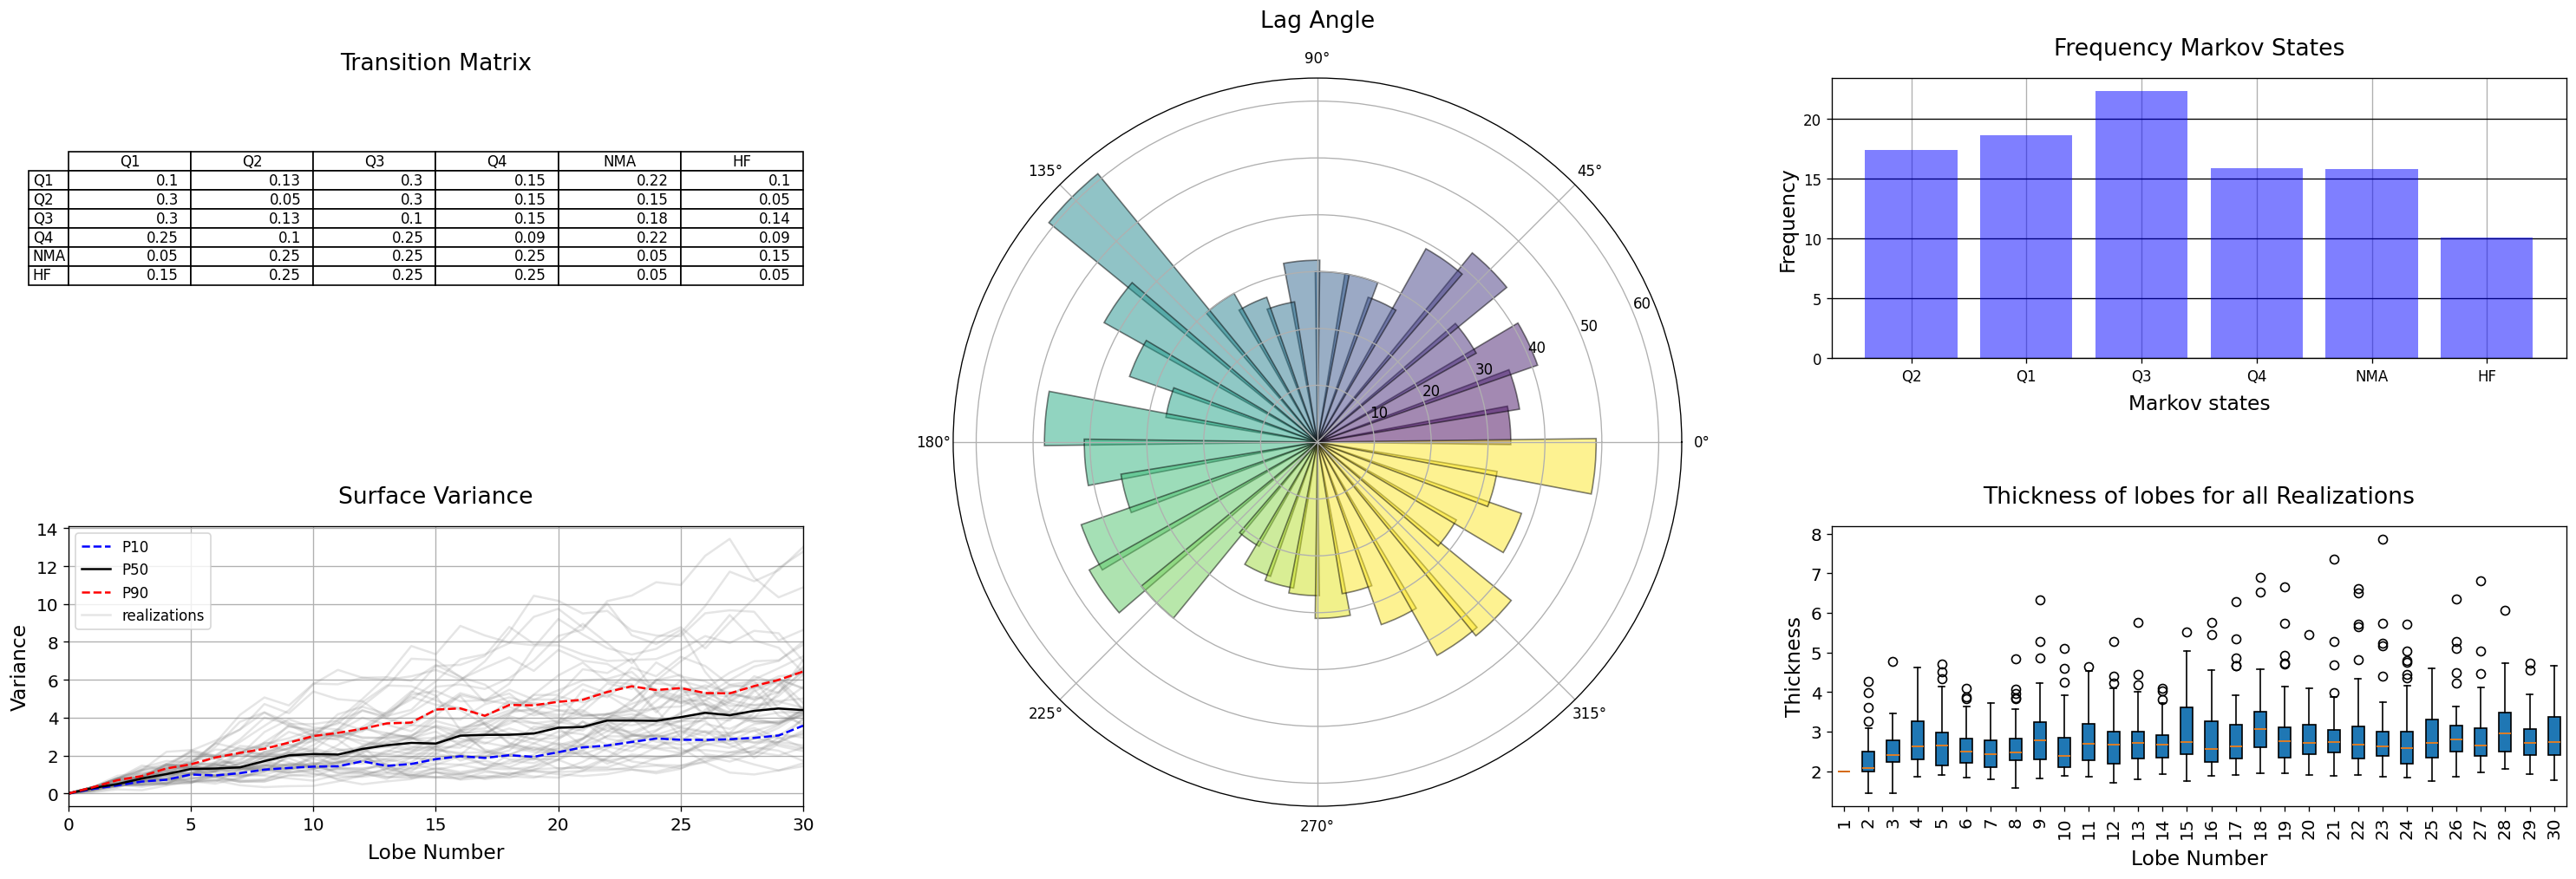

In [12]:
fig = plt.figure(figsize=(12, 7),dpi=120)
grid_spec = gridspec.GridSpec(ncols = 3,nrows=2,width_ratios=[2, 2, 2])

ax0 = fig.add_subplot(grid_spec[0])
ax0.axis('tight')
ax0.axis('off')
the_table = ax0.table(cellText=transition_matrix,rowLabels=rows,colLabels=columns,loc='center')
plt.title('Transition Matrix', fontsize=16)

ax1 = fig.add_subplot(grid_spec[1])
ax1.axis('off')
# Plot polar bar graph
# Get an axes handle/object
ax1 = plt.subplot(projection ="polar")
# Plot
bars = ax1.bar(x = pairlist_mean, height= angle_counts,
        color=plt.cm.viridis(pairlist_mean/ 5.),
        width=0.2,
        bottom=0.0,
        alpha=0.5,
        edgecolor='k')
# Additional Tweaks
plt.grid(True)
plt.title("Lag Angle", fontsize=16, pad=16)

ax2= fig.add_subplot(grid_spec[2])
# Plot the bar graph
plt.grid()
plt.bar(quadrants, frequencies_percentage, color='blue', zorder=2,alpha =0.5)
# Plot the grid with a lower zorder value
plt.grid(axis='y', zorder=1,color ='black')
plt.xlabel('Markov states',fontsize=14,labelpad=7)
plt.ylabel('Frequency',fontsize=14)
plt.title('Frequency Markov States', fontsize=16, pad=16)

### Percentiles
##### plot variance vs surface and percentiles
ax3 = fig.add_subplot(grid_spec[3])

bathy_lenght = list(range(0,n_lobes+1))
for n in range(n_test):

    # # set the title of a plot 
    plt.title("Surface Variance", fontsize=16, pad=16)

    # # plot scatter plot with x and y data 
    plt.plot(bathy_lenght,array_variances_percentiles[:,n],alpha=0.2,color ="gray") 
#label different realizations
line = Line2D([0], [0], label='realizations', color='gray',alpha =0.2)

plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+1],"b--", label = 'P10') #p10
plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+2],"k", label = 'P50') #p50
plt.plot(bathy_lenght,array_variances_percentiles[:,n_test+3],"r--", label = 'P90') #p90 

plt.xlim([0, n_lobes]) 
plt.xlabel('Lobe Number',fontsize=14,labelpad=7)
plt.ylabel('Variance',fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
#legend
handles, labels = ax3.get_legend_handles_labels()
handles.append(line)
plt.legend(handles=handles)


### Lobe thickness
ax5 = fig.add_subplot(grid_spec[5])
labels = list(map(str, range(1, n_lobes+1)))

#boxplot
plt.boxplot(lobe_thickness_list, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('Thickness',fontsize=14)
plt.xlabel('Lobe Number',fontsize=14,labelpad=7)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Thickness of lobes for all Realizations", fontsize=16, pad=16)



plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.6); plt.show()

In [ ]:
#desaparecer recuadro # done
#font size #done
#separar input data de data processing
#hacer buena descripcion del notebook
#incluir 3D input

In [ ]:
### Load Data

#list that will have quadrants (Markov State) for every realization
total_quadrants = []
# list that will have all the centroids for every realization
total_centroids = []

for n in range(1,n_test+1):
    #combine the lists of quadrants
    total_quadrants = total_quadrants +  load_list_json("quadrants{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/')
    total_centroids.append(load_array("centroids{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/centroids/'))

In [ ]:
### Transition Matrix plot
columns = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')
rows = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')

### Frequency of Markov-States
# Calculate the frequency of each quadrant
frequency_counter = Counter(total_quadrants)

# Extract the quadrants and their frequencies
quadrants = list(frequency_counter.keys())
frequencies = list(frequency_counter.values())

#Calculate percentages from frequencies
frequencies_percentage = [ i * 100/sum(frequencies) for i in frequencies]

### Lag angle plot
# Find the angles at which centroids move.
angles = []

for n in range(1,n_test+1): 

    centroids =  load_array("centroids{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/centroids/')
     
    #Remove rows containing "nan" values
    # Find rows that do not contain NaN values
    valid_rows = ~np.isnan(centroids).any(axis=1)

    # Use boolean indexing to select rows without NaN
    centroids = centroids[valid_rows]

    # Find the angle between three points - the reference point is grid center

    for i in range(len(centroids)-1):
        a = centroids[i]
        b = centroids[i+1]
        start_coordinate = np.array([0,a[1]])

        angles.append(angle_between(a, start_coordinate,b))


# polar bar plot - prep
theta = np.linspace(0,360,37)
# Create pais in the theta using list comprehension
theta_pairlist = [[theta[i], theta[i + 1]] for i in range(0, len(theta)-1)]

# #Convert lists to numpy arrays for easier manipulation
angles_array = np.array(angles)
intervals_array = np.array(theta_pairlist)

# #Initialize a list to store the count of angles in each interval
angle_counts = [] 

for interval in intervals_array:
    # Filter angles within the current interval
    filtered_angles = angles_array[(angles_array >= interval[0]) & (angles_array < interval[1])]

    # Count the number of angles in the interval
    count = len(filtered_angles)

    # Store the count in the list
    angle_counts.append(count)


# #calculate the mean of each pair to be able to plot it 
pairlist_mean = [int(sum(pair) / len(pair)) for pair in theta_pairlist]

#transform the pairlist_mean from degrees to radians
pairlist_mean = np.radians(pairlist_mean)
#transform angle_counts from list to an array
angle_counts = np.array(angle_counts)


#create array of zeros to store the variances of the bathymetry maps
#Add four columns to the array to accommodate space for p10, p25, p85, and p90 values for each row.
#Add one row, as there are n_lobes + 1 bathymetry maps, with the first one being just an array of zeros.
array_variances_percentiles = np.zeros((n_lobes+1,n_test+5))


for n in range(1,n_test+1): 

    variance_bathymetry =  load_array("variance_thickness{}".format(n),"/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/surface_variance/")
    array_variances_percentiles[:,n] = variance_bathymetry


#Find P10, P25, P85 and P90

for n in range(n_lobes+1):
    #p10
    array_variances_percentiles[n,n_test] = np.percentile(array_variances_percentiles[n,:n_test],10)
    #p25
    array_variances_percentiles[n,n_test+1] = np.percentile(array_variances_percentiles[n,:n_test],25)
    #p50
    array_variances_percentiles[n,n_test+2] = np.percentile(array_variances_percentiles[n,:n_test],50)
    #p75
    array_variances_percentiles[n,n_test+3] = np.percentile(array_variances_percentiles[n,:n_test],75)
    #p90
    array_variances_percentiles[n,n_test+4] = np.percentile(array_variances_percentiles[n,:n_test],90)



#####Thickness box-plot
#array for saving max thickness for each lobe on each realization
lobe_thickness_realizations = np.zeros((n_lobes, n_test))

#Data prep
for n in range(1,n_test+1):
    #Load quadrants for each realization
    output_quadrants = load_list_json("quadrants{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/')
    #Load bathymetry maps
    bathymetry_array =  load_array("bathy_array{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/')
    #Remove the first bathymetry map from the bathymetry array as it doesn't contain any lobes (only zeros).
    bathymetry_array = bathymetry_array[1:len(bathymetry_array),:,:]


    for i in range(len(output_quadrants)): 
        if output_quadrants[i] != "HF":
            if i == 0:
                lobe_thickness_realizations[i,n-1] = np.max(bathymetry_array[0,:,:])
            else:
                lobe_thickness_realizations[i,n-1] = lobe_max_thickness(bathymetry_array[i-1,:,:],bathymetry_array[i,:,:])


# Replace zeros with the mean of each column (lobe)
lobe_thickness_nan = np.where(lobe_thickness_realizations == 0, np.nan, lobe_thickness_realizations)
# Calculate the mean of each column excluding NaN values
col_means = np.nanmean(lobe_thickness_nan, axis=0)
# Replace zeros with the mean of each column
lobe_thickness_no_zeros = np.where(lobe_thickness_realizations == 0, col_means, lobe_thickness_realizations)


# #create a list of lists with the thickneses for the  n_lobes for the n_test realizations.
lobe_thickness_list = [row.tolist() for row in lobe_thickness_no_zeros]

